<a href="https://colab.research.google.com/github/Marco75116/AlerteSms/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=EUR&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
# colonne cible
target_col = 'close'
# maj API, suppression des 2 colonnes string
hist_eth = hist.drop(['conversionType','conversionSymbol'], axis=1)

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
# colonne cible
target_col = 'close'
# maj API, suppression des 2 colonnes string
hist_btc = hist.drop(['conversionType','conversionSymbol'], axis=1)

In [ ]:
df = pd.DataFrame({'BTC': hist_btc.close,
                   'ETH': hist_eth.close})
df.head(10) 

,BTC,ETH
time,,
2020-08-25,9594.61,324.59
2020-08-26,9693.73,326.29
2020-08-27,9595.58,324.33
2020-08-28,9705.52,332.80
2020-08-29,9668.58,335.98
2020-08-30,9838.41,360.38
2020-08-31,9783.75,364.35
2020-09-01,10008.41,399.44
2020-09-02,9641.23,372.06


In [ ]:
np.random.seed(7)
dataset = df.values
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler_btc = MinMaxScaler(feature_range=(0, 1))
scaler_eth = MinMaxScaler(feature_range=(0, 1))
dataset[:,0] = scaler_btc.fit_transform(dataset[:,0].reshape(-1,1)).reshape(-1)
dataset[:,1] = scaler_eth.fit_transform(dataset[:,1].reshape(-1,1)).reshape(-1)


In [ ]:
np.random.seed(42)

window_len = 5
zero_base = True
lstm_neurons = 100
epochs = 200
batch_size = 16
loss = 'mean_squared_error'
dropout = 0
optimizer = 'adam'

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 1])
    return np.array(dataX), np.array(dataY)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [ ]:
trainX, trainY = create_dataset(train, window_len)  
testX, testY   = create_dataset(test, window_len)

In [ ]:
trainX.shape   

(329, 5, 2)

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=( input_data.shape[1], input_data.shape[2] )    ))
    model.add(Dense(output_size))
    # model.add(Dropout(dropout))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], window_len, 2))
testX  = np.reshape(testX, (testX.shape[0],window_len, 2))

In [ ]:
model = build_lstm_model(trainX,output_size=1,neurons=lstm_neurons,dropout=dropout,optimizer=optimizer)

In [ ]:
history= model.fit(trainX, trainY,validation_split=0.33, epochs=epochs, batch_size=batch_size)

Epoch 1/200
14/14 [==============================] - 2s 41ms/step - loss: 0.0034 - val_loss: 0.0485
Epoch 2/200
14/14 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0332
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 7.9574e-04 - val_loss: 0.0391
Epoch 4/200
14/14 [==============================] - 0s 7ms/step - loss: 6.9200e-04 - val_loss: 0.0326
Epoch 5/200
14/14 [==============================] - 0s 7ms/step - loss: 6.3896e-04 - val_loss: 0.0276
Epoch 6/200
14/14 [==============================] - 0s 8ms/step - loss: 5.8973e-04 - val_loss: 0.0214
Epoch 7/200
14/14 [==============================] - 0s 8ms/step - loss: 5.6498e-04 - val_loss: 0.0232
Epoch 8/200
14/14 [==============================] - 0s 8ms/step - loss: 5.3738e-04 - val_loss: 0.0185
Epoch 9/200
14/14 [==============================] - 0s 6ms/step - loss: 5.2156e-04 - val_loss: 0.0137
Epoch 10/200
14/14 [==============================] - 0s 7ms/step - loss: 4.1983

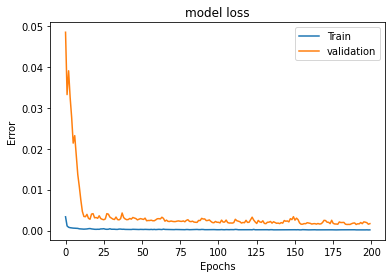

In [ ]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# make predictions
testPredict = model.predict(testX)

In [ ]:
testY_o = scaler_eth.inverse_transform(testY.reshape(-1, 1))
testPredict_o = scaler_eth.inverse_transform(testPredict)

testScore  = mean_absolute_error(testY_o, testPredict_o)
print('Test Score: %.2f MAE' % (testScore))

Test Score: 218.05 MAE


In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [EUR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

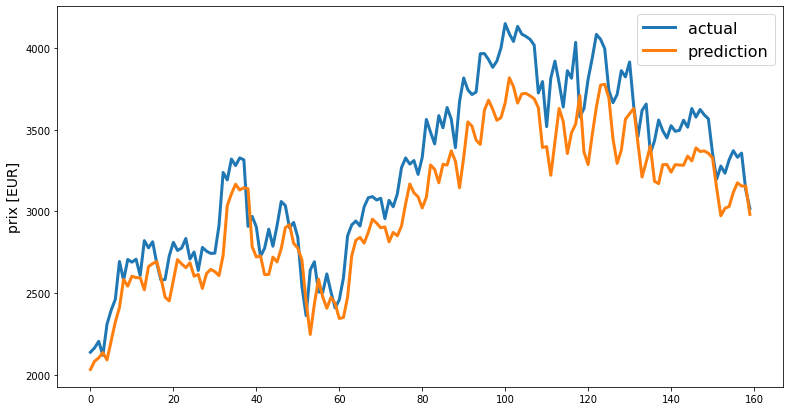

In [ ]:
line_plot(testY_o, testPredict_o, 'actual', 'prediction', lw=3)